In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [3]:
fileName = 'C:/Users/mcarp/Downloads/usa_00008.csv/usa_00008.csv'
file = pd.read_csv(fileName)
dfCDI = pd.DataFrame(file)

In [4]:
fileName2 = 'C:/Users/mcarp/Downloads/county_merged2010.xlsx - Sheet1.csv'
file2 = pd.read_csv(fileName2)
dfCty = pd.DataFrame(file2)

In [5]:
dfCDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753741 entries, 0 to 1753740
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   YEAR        int64  
 1   MULTYEAR    int64  
 2   SAMPLE      int64  
 3   SERIAL      int64  
 4   CBSERIAL    int64  
 5   HHWT        float64
 6   CLUSTER     int64  
 7   CPI99       float64
 8   STATEFIP    int64  
 9   COUNTYFIP   int64  
 10  DENSITY     float64
 11  CITY        int64  
 12  PUMA        int64  
 13  STRATA      int64  
 14  GQ          int64  
 15  OWNERSHP    int64  
 16  OWNERSHPD   int64  
 17  OWNCOST     int64  
 18  RENTGRS     int64  
 19  HHINCOME    int64  
 20  PERNUM      int64  
 21  PERWT       float64
 22  FAMSIZE     int64  
 23  AGE         int64  
 24  RACE        int64  
 25  RACED       int64  
 26  HISPAN      int64  
 27  HISPAND     int64  
 28  EDUC        int64  
 29  EDUCD       int64  
 30  OCCSOC      object 
 31  INDNAICS    object 
 32  INCTOT      int64  
 33  FTOTINC

In [6]:
dfCDI.shape

(1753741, 38)

In [7]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(1253598, 38)

In [8]:
dfCDI.RENTGRS.value_counts()

0       860271
810       1569
800       1394
1220      1377
820       1334
         ...  
49           1
4146         1
3025         1
3787         1
3608         1
Name: RENTGRS, Length: 3925, dtype: int64

In [9]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    810238.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: RENTGRS, dtype: float64

This reveals that home owning rows all have 0 values for cost of rent.

In [10]:
dfCDI['OWNERSHP'].value_counts()

1    810238
2    409307
0     34053
Name: OWNERSHP, dtype: int64

In [11]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(1219545, 38)

Removes N/As (~50k rows)

In [12]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [13]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [14]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    810238
1    213086
0    196221
Name: HousingCat, dtype: int64

COMBINING aff. rent and home ownership into 1 indicator: 0, 1, 2 scores (0: rent>=30% income, 1: rent<30% income, 2: owner)

In [15]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    738291
1    481254
Name: EDUCbin, dtype: int64

In [18]:
dfCDI['TRANTIME'].value_counts()

0      530850
15     101569
30     100776
20      99530
10      83993
        ...  
126         1
82          1
94          1
92          1
86          1
Name: TRANTIME, Length: 126, dtype: int64

In [19]:
dfCDI.shape

(1219545, 41)

In [20]:
joined2019_2 = dfCDI.merge(dfCty, on='COUNTYFIP')
joined2019_2.shape

(1170510, 58)

In [21]:
print(joined2019_2.columns.get_loc("HousingCat"))
print(joined2019_2.columns.get_loc("EDUCbin"))
print(joined2019_2.columns.get_loc("TRANTIME"))
print(joined2019_2.columns.get_loc("DrinkingWater"))
print(joined2019_2.columns.get_loc("AirQuality"))
print(joined2019_2.columns.get_loc("EarlyEd"))
print(joined2019_2.columns.get_loc("ProspNeigh"))

39
40
37
54
56
55
57


In [22]:
X = joined2019_2.iloc[:, [39,40,37,54,56,55,57]]

In [23]:
X.describe()

,HousingCat,EDUCbin,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.170510e+06,1.170510e+06,1.170510e+06,1170510.0,1.170510e+06,1.170510e+06,1.170510e+06
mean,1.499936e+00,3.981188e-01,1.560110e+01,1.0,3.486640e+01,5.090249e-01,8.312623e-01
std,7.582193e-01,4.895104e-01,2.179290e+01,0.0,7.366761e+00,7.035853e-02,9.973130e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.900000e+01,3.300000e-01,5.633676e-01
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.0,2.700000e+01,4.790000e-01,7.498056e-01
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.0,3.800000e+01,5.320000e-01,8.438507e-01
75%,2.000000e+00,1.000000e+00,2.500000e+01,1.0,4.100000e+01,5.380000e-01,9.269250e-01
max,2.000000e+00,1.000000e+00,1.780000e+02,1.0,4.400000e+01,7.400000e-01,1.000000e+00


In [24]:
scaler=StandardScaler()
scalerNum = scaler.fit(X)
Xstd = scalerNum.transform(X)

In [26]:
dfX = pd.DataFrame(Xstd, columns=['HousingCat','EDUCbin','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh'])
dfX.describe()

,HousingCat,EDUCbin,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.170510e+06,1.170510e+06,1.170510e+06,1170510.0,1.170510e+06,1.170510e+06,1.170510e+06
mean,7.169730e-13,-4.328006e-13,9.084261e-14,0.0,1.100339e-12,1.124357e-12,1.141147e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.978236e+00,-8.133003e-01,-7.158803e-01,0.0,-2.153784e+00,-2.544467e+00,-2.686166e+00
25%,-6.593556e-01,-8.133003e-01,-7.158803e-01,0.0,-1.067824e+00,-4.267416e-01,-8.167623e-01
50%,6.595246e-01,-8.133003e-01,-2.570151e-01,0.0,4.253698e-01,3.265434e-01,1.262227e-01
75%,6.595246e-01,1.229558e+00,4.312827e-01,0.0,8.326046e-01,4.118209e-01,9.592045e-01
max,6.595246e-01,1.229558e+00,7.451921e+00,0.0,1.239839e+00,3.282831e+00,1.691924e+00


elbow method:

silhouette score:

In [27]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans.fit(dfX)
print(kmeans.labels_)

[3 3 3 ... 0 2 1]


In [28]:
Xfin = scaler.inverse_transform(dfX)
Xfin

array([[ 2.        ,  0.        ,  0.        , ..., 24.        ,
         0.577     ,  0.95378249],
       [ 2.        ,  0.        ,  0.        , ..., 24.        ,
         0.577     ,  0.95378249],
       [ 2.        ,  0.        ,  0.        , ..., 24.        ,
         0.577     ,  0.95378249],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 40.        ,
         0.355     ,  0.77457972],
       [ 2.        ,  0.        ,  2.        , ..., 40.        ,
         0.355     ,  0.77457972],
       [ 2.        ,  1.        ,  5.        , ..., 40.        ,
         0.355     ,  0.77457972]])

In [29]:
dfXfin = pd.DataFrame(Xfin, columns=['HousingCat','EDUCbin','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh'])
dfXfin.describe()

,HousingCat,EDUCbin,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
count,1.170510e+06,1.170510e+06,1.170510e+06,1170510.0,1.170510e+06,1.170510e+06,1.170510e+06
mean,1.499936e+00,3.981188e-01,1.560110e+01,1.0,3.486640e+01,5.090249e-01,8.312623e-01
std,7.582193e-01,4.895104e-01,2.179290e+01,0.0,7.366761e+00,7.035853e-02,9.973130e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.900000e+01,3.300000e-01,5.633676e-01
25%,1.000000e+00,0.000000e+00,0.000000e+00,1.0,2.700000e+01,4.790000e-01,7.498056e-01
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.0,3.800000e+01,5.320000e-01,8.438507e-01
75%,2.000000e+00,1.000000e+00,2.500000e+01,1.0,4.100000e+01,5.380000e-01,9.269250e-01
max,2.000000e+00,1.000000e+00,1.780000e+02,1.0,4.400000e+01,7.400000e-01,1.000000e+00


In [30]:
dfXfin['labels'] = kmeans.labels_
cluster_sum = dfXfin.groupby(by = 'labels').mean()
cluster_sum.head()

,HousingCat,EDUCbin,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
labels,,,,,,,
0,0.297571,0.144018,11.624143,1.0,37.809882,0.508641,0.801258
1,1.820293,1.000000,13.875369,1.0,38.154047,0.494141,0.806277
2,1.921969,0.000000,9.443645,1.0,38.274098,0.469645,0.785771
3,1.620814,0.525884,14.068875,1.0,24.467513,0.576485,0.940207
4,1.662427,0.413673,78.653317,1.0,37.117589,0.494400,0.818774


In [31]:
clust0 = dfXfin[dfXfin['labels']==0]
clust1 = dfXfin[dfXfin['labels']==1]
clust2 = dfXfin[dfXfin['labels']==2]
clust3 = dfXfin[dfXfin['labels']==3]
clust4 = dfXfin[dfXfin['labels']==4]
#clust5 = dfXfin[dfXfin['labels']==5]
#clust6 = dfXfin[dfXfin['labels']==6]

## Housing Category

In [32]:
clust0['HousingCat'].value_counts()

0.0    159426
1.0     67538
Name: HousingCat, dtype: int64

In [33]:
clust1['HousingCat'].value_counts()

2.0    216363
1.0     47400
Name: HousingCat, dtype: int64

In [34]:
clust2['HousingCat'].value_counts()

2.0    317326
1.0     26857
Name: HousingCat, dtype: int64

In [35]:
clust3['HousingCat'].value_counts()

2.0    196308
1.0     51163
0.0     26329
Name: HousingCat, dtype: int64

In [36]:
clust4['HousingCat'].value_counts()

2.0    45330
1.0    12078
0.0     4392
Name: HousingCat, dtype: int64

In [37]:
# TABLE

## Education (binary)

In [38]:
clust0['EDUCbin'].value_counts()

0.0    194277
1.0     32687
Name: EDUCbin, dtype: int64

In [39]:
clust1['EDUCbin'].value_counts()

1.0    263763
Name: EDUCbin, dtype: int64

In [40]:
clust2['EDUCbin'].value_counts()

0.0    344183
Name: EDUCbin, dtype: int64

In [41]:
clust3['EDUCbin'].value_counts()

1.0    143987
0.0    129813
Name: EDUCbin, dtype: int64

In [42]:
clust4['EDUCbin'].value_counts()

0.0    36235
1.0    25565
Name: EDUCbin, dtype: int64

In [ ]:
#TABLE


## Commute Time

(array([120154.,  18839.,  20473.,  26261.,  21642.,   2939.,  12200.,
           768.,    158.,   3530.]),
 array([ 0. ,  6.5, 13. , 19.5, 26. , 32.5, 39. , 45.5, 52. , 58.5, 65. ]),
 <BarContainer object of 10 artists>)

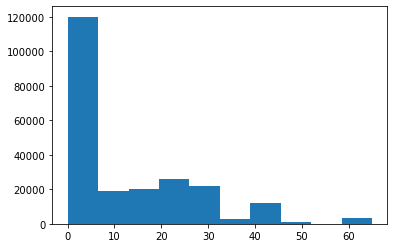

In [43]:
matplotlib.pyplot.hist(clust0['TRANTIME'])

(array([112149.,  25656.,  29150.,  28081.,  12064.,  26856.,   5971.,
          8418.,  12152.,   3266.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <BarContainer object of 10 artists>)

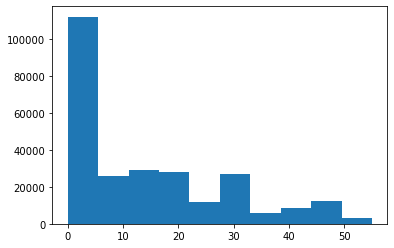

In [44]:
matplotlib.pyplot.hist(clust1['TRANTIME'])

(array([200348.,  27686.,  30460.,  28037.,  10882.,  26591.,   4556.,
          6811.,   8039.,    773.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <BarContainer object of 10 artists>)

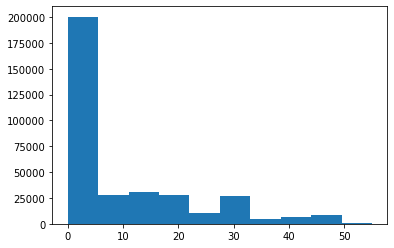

In [45]:
matplotlib.pyplot.hist(clust2['TRANTIME'])

(array([1.32784e+05, 4.64840e+04, 3.39030e+04, 2.88270e+04, 1.91850e+04,
        3.82400e+03, 8.27000e+03, 4.44000e+02, 1.00000e+01, 6.90000e+01]),
 array([ 0. ,  9.5, 19. , 28.5, 38. , 47.5, 57. , 66.5, 76. , 85.5, 95. ]),
 <BarContainer object of 10 artists>)

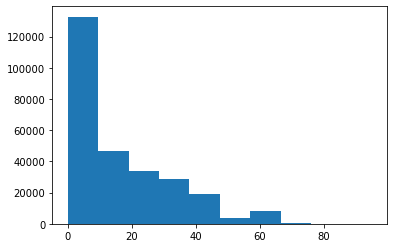

In [46]:
matplotlib.pyplot.hist(clust3['TRANTIME'])

(array([ 7006., 27873.,  5948., 10683.,  1604.,  2988.,    89.,  3319.,
            0.,  2290.]),
 array([ 45. ,  58.3,  71.6,  84.9,  98.2, 111.5, 124.8, 138.1, 151.4,
        164.7, 178. ]),
 <BarContainer object of 10 artists>)

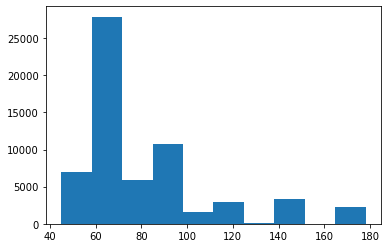

In [47]:
matplotlib.pyplot.hist(clust4['TRANTIME'])

## Clean Drinking Water

(array([     0.,      0.,      0.,      0.,      0., 226964.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

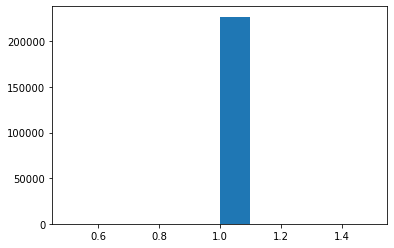

In [48]:
matplotlib.pyplot.hist(clust0['DrinkingWater'])

(array([     0.,      0.,      0.,      0.,      0., 263763.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

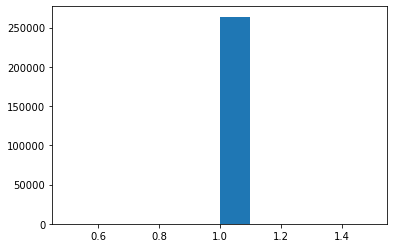

In [49]:
matplotlib.pyplot.hist(clust1['DrinkingWater'])

(array([     0.,      0.,      0.,      0.,      0., 344183.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

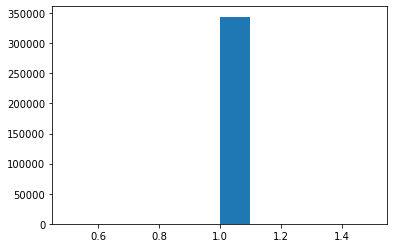

In [50]:
matplotlib.pyplot.hist(clust2['DrinkingWater'])

(array([     0.,      0.,      0.,      0.,      0., 273800.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

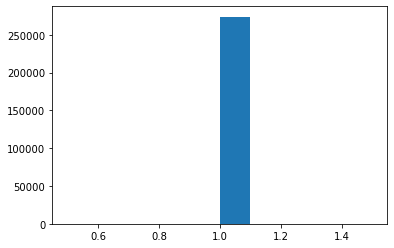

In [51]:
matplotlib.pyplot.hist(clust3['DrinkingWater'])

(array([    0.,     0.,     0.,     0.,     0., 61800.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

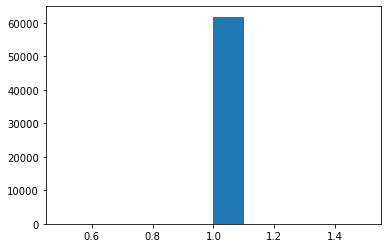

In [52]:
matplotlib.pyplot.hist(clust4['DrinkingWater'])

## Air Quality

(array([  1295.,   6989.,  15805.,   6791.,   1243.,   6748.,  37025.,
         30775., 102855.,  17438.]),
 array([21. , 23.3, 25.6, 27.9, 30.2, 32.5, 34.8, 37.1, 39.4, 41.7, 44. ]),
 <BarContainer object of 10 artists>)

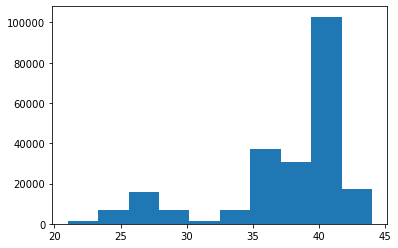

In [53]:
matplotlib.pyplot.hist(clust0['AirQuality'])

(array([  1942.,  20598.,   4976.,      0.,   6911.,  13760.,  89365.,
           975., 109981.,  15255.]),
 array([25. , 26.9, 28.8, 30.7, 32.6, 34.5, 36.4, 38.3, 40.2, 42.1, 44. ]),
 <BarContainer object of 10 artists>)

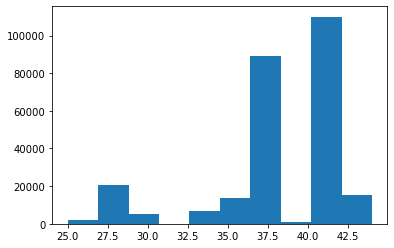

In [54]:
matplotlib.pyplot.hist(clust1['AirQuality'])

(array([  4007.,  27909.,   4679.,      0.,  15561.,  34947.,  77750.,
          2795., 137160.,  39375.]),
 array([25. , 26.9, 28.8, 30.7, 32.6, 34.5, 36.4, 38.3, 40.2, 42.1, 44. ]),
 <BarContainer object of 10 artists>)

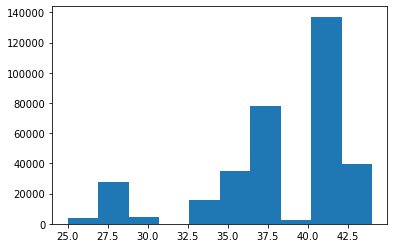

In [55]:
matplotlib.pyplot.hist(clust2['AirQuality'])

(array([50162., 25788., 60450., 82962.,  5493., 24736.,     0.,  7508.,
        11221.,  5480.]),
 array([19. , 20.7, 22.4, 24.1, 25.8, 27.5, 29.2, 30.9, 32.6, 34.3, 36. ]),
 <BarContainer object of 10 artists>)

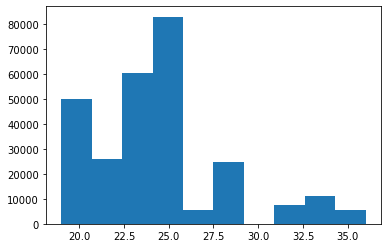

In [56]:
matplotlib.pyplot.hist(clust3['AirQuality'])

(array([ 3010.,    54.,  2678.,  5094.,   845.,   446.,  3967., 13326.,
        21365., 11015.]),
 array([19. , 21.5, 24. , 26.5, 29. , 31.5, 34. , 36.5, 39. , 41.5, 44. ]),
 <BarContainer object of 10 artists>)

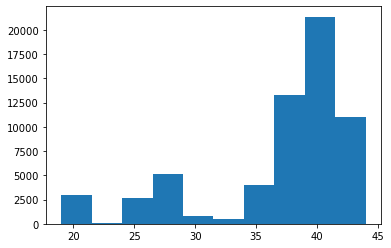

In [57]:
matplotlib.pyplot.hist(clust4['AirQuality'])

## Early Education

(array([  1683.,  13802.,  14903.,   4628.,      0.,  42374.,  36337.,
        104016.,   6068.,   3153.]),
 array([0.33  , 0.3595, 0.389 , 0.4185, 0.448 , 0.4775, 0.507 , 0.5365,
        0.566 , 0.5955, 0.625 ]),
 <BarContainer object of 10 artists>)

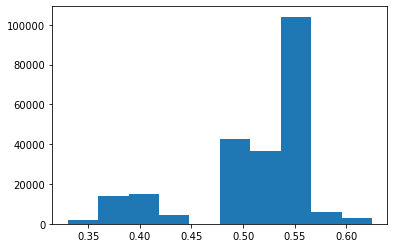

In [58]:
matplotlib.pyplot.hist(clust0['EarlyEd'])

(array([  1395.,   6129.,  20983.,  23143.,   1942.,   4666.,      0.,
         20908.,  41844., 142753.]),
 array([0.33  , 0.3508, 0.3716, 0.3924, 0.4132, 0.434 , 0.4548, 0.4756,
        0.4964, 0.5172, 0.538 ]),
 <BarContainer object of 10 artists>)

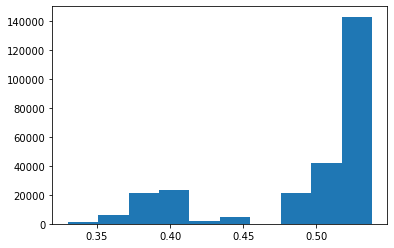

In [59]:
matplotlib.pyplot.hist(clust1['EarlyEd'])

(array([  4538.,  17667.,  49924.,  54775.,   4007.,  11038.,      0.,
         21550.,  35927., 144757.]),
 array([0.33  , 0.3508, 0.3716, 0.3924, 0.4132, 0.434 , 0.4548, 0.4756,
        0.4964, 0.5172, 0.538 ]),
 <BarContainer object of 10 artists>)

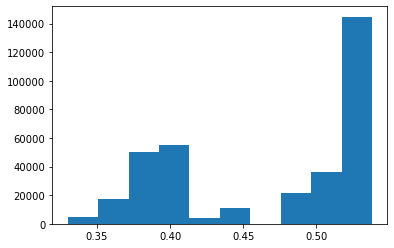

In [60]:
matplotlib.pyplot.hist(clust2['EarlyEd'])

(array([ 11217.,      0.,  24876.,  19416., 109017.,  75662.,  24736.,
             0.,      0.,   8876.]),
 array([0.431 , 0.4619, 0.4928, 0.5237, 0.5546, 0.5855, 0.6164, 0.6473,
        0.6782, 0.7091, 0.74  ]),
 <BarContainer object of 10 artists>)

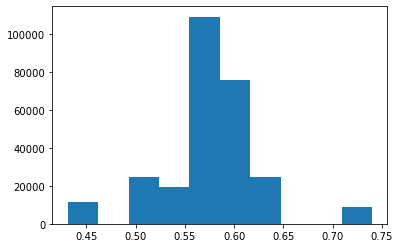

In [61]:
matplotlib.pyplot.hist(clust3['EarlyEd'])

(array([ 1448., 12950.,  3332.,  2370., 14982., 23005.,  3058.,   608.,
            0.,    47.]),
 array([0.33 , 0.371, 0.412, 0.453, 0.494, 0.535, 0.576, 0.617, 0.658,
        0.699, 0.74 ]),
 <BarContainer object of 10 artists>)

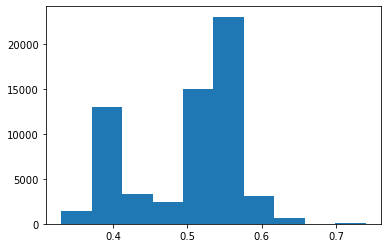

In [62]:
matplotlib.pyplot.hist(clust4['EarlyEd'])

## Prosperous Neighborhoods

(array([  6541.,   4272.,   1990.,      0., 102855.,  17824.,  49235.,
          5269.,  37725.,   1253.]),
 array([0.56336763, 0.60703086, 0.6506941 , 0.69435734, 0.73802058,
        0.78168381, 0.82534705, 0.86901029, 0.91267353, 0.95633676,
        1.        ]),
 <BarContainer object of 10 artists>)

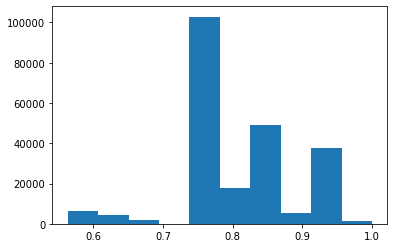

In [63]:
matplotlib.pyplot.hist(clust0['ProspNeigh'])

(array([10145.,  5154.,  3264.,     0.,     0., 93767., 18929., 81864.,
            0., 50640.]),
 array([0.56336763, 0.59975012, 0.63613262, 0.67251511, 0.7088976 ,
        0.7452801 , 0.78166259, 0.81804509, 0.85442758, 0.89081008,
        0.92719257]),
 <BarContainer object of 10 artists>)

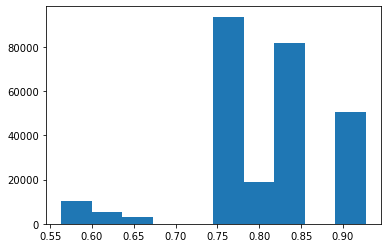

In [64]:
matplotlib.pyplot.hist(clust1['ProspNeigh'])

(array([ 25259.,  14872.,   9608.,      0.,      0., 102376.,  44698.,
        103708.,      0.,  43662.]),
 array([0.56336763, 0.59975012, 0.63613262, 0.67251511, 0.7088976 ,
        0.7452801 , 0.78166259, 0.81804509, 0.85442758, 0.89081008,
        0.92719257]),
 <BarContainer object of 10 artists>)

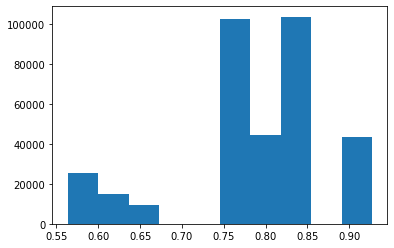

In [65]:
matplotlib.pyplot.hist(clust2['ProspNeigh'])

(array([44540.,     0.,     0., 57530., 13721., 32153., 60450., 22848.,
        31337., 11221.]),
 array([0.88109044, 0.8929814 , 0.90487236, 0.91676331, 0.92865427,
        0.94054522, 0.95243618, 0.96432713, 0.97621809, 0.98810904,
        1.        ]),
 <BarContainer object of 10 artists>)

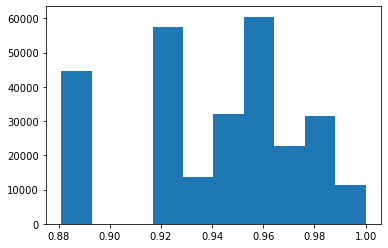

In [66]:
matplotlib.pyplot.hist(clust3['ProspNeigh'])

(array([ 1145.,  1335.,   302.,     0., 21365.,  8154., 13692.,  1089.,
        12983.,  1735.]),
 array([0.56336763, 0.60703086, 0.6506941 , 0.69435734, 0.73802058,
        0.78168381, 0.82534705, 0.86901029, 0.91267353, 0.95633676,
        1.        ]),
 <BarContainer object of 10 artists>)

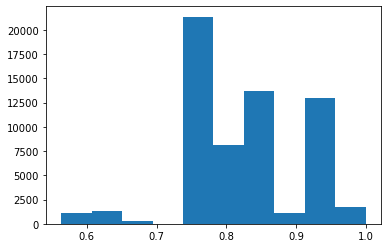

In [67]:
matplotlib.pyplot.hist(clust4['ProspNeigh'])

## Feature Correlations

In [70]:
Xcorr=dfXfin.iloc[:, [0,1,2,3,4,5,6]]
Xcorr.head()

,HousingCat,EDUCbin,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
0,2.0,0.0,0.0,1.0,24.0,0.577,0.953782
1,2.0,0.0,0.0,1.0,24.0,0.577,0.953782
2,2.0,0.0,0.0,1.0,24.0,0.577,0.953782
3,2.0,0.0,0.0,1.0,24.0,0.577,0.953782
4,2.0,1.0,20.0,1.0,24.0,0.577,0.953782


<AxesSubplot:>

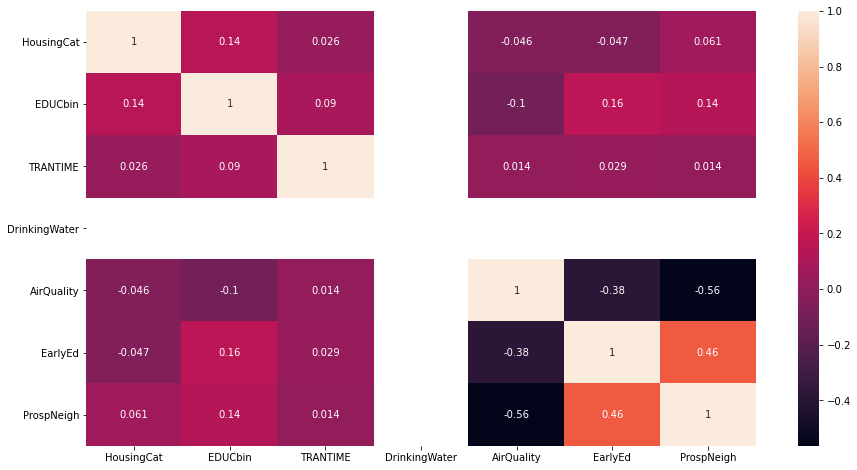

In [71]:
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr.corr(), annot = True)